In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
import time as tm
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

## Settings

In [2]:
sns.set_style('white')
sns.set_context('paper', font_scale=2)
plt.xkcd();

In [3]:
torch.multiprocessing.set_sharing_strategy("file_system")
pyro.set_rng_seed(42)

In [4]:
device = torch.device('cuda:0')

In [5]:
NUM_WARMUP = 1000
NUM_SAMPLES = 1000
NUM_CHAINS = 1
N = 2500
P = 2

## Generate some model and data
### Generate the model parameters

In [6]:
alpha_true = dist.Normal(42.0, 10.0).sample()
beta_true = dist.Normal(torch.zeros(P), 10.0).sample()
sigma_true = dist.Exponential(1.0).sample()

alpha_true, beta_true, sigma_true

(tensor(45.3669), tensor([1.2881, 2.3446]), tensor(0.7469))

### Generate synthetic data

In [7]:
eps = dist.Normal(0.0, sigma_true).sample([N])
X = torch.randn(N, P)
y = alpha_true + X @ beta_true + eps

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
def Xy2df(X, y):
    data = torch.hstack([X_train,y_train.reshape((-1,1))])
    columns = [f"x{p}" for p in range(0,P)] + ['y']
    return pd.DataFrame(data=data, columns=columns )

train_df = Xy2df(X_train,y_train)
test_df = Xy2df(X_test,y_test)
train_df

,x0,x1,y
0,0.080740,0.769340,47.701660
1,1.144735,-1.369290,43.206566
2,-0.521719,0.375682,44.689064
3,1.302058,0.058206,48.818462
4,-0.448526,0.525732,46.440952
...,...,...,...
1670,-0.108758,0.713503,47.202782
1671,-0.854471,-0.835770,43.350742
1672,-1.179386,-0.954055,41.232998
1673,-1.268905,-0.242328,43.340527


## Scale the data, this is good for modelling with Pyro

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_df)
train_scaled_df = pd.DataFrame(data=scaler.transform(train_df), columns=train_df.columns)
test_scaled_df = pd.DataFrame(data=scaler.transform(test_df), columns=test_df.columns)
train_scaled_df

,x0,x1,y
0,0.090152,0.730950,0.812289
1,1.137819,-1.436771,-0.812953
2,-0.503062,0.331937,-0.276943
3,1.292728,0.010143,1.216079
4,-0.430992,0.484028,0.356468
...,...,...,...
1670,-0.096438,0.674353,0.631915
1671,-0.830707,-0.895993,-0.760825
1672,-1.150636,-1.015887,-1.526515
1673,-1.238782,-0.294479,-0.764519


### Do some exploratory analysis

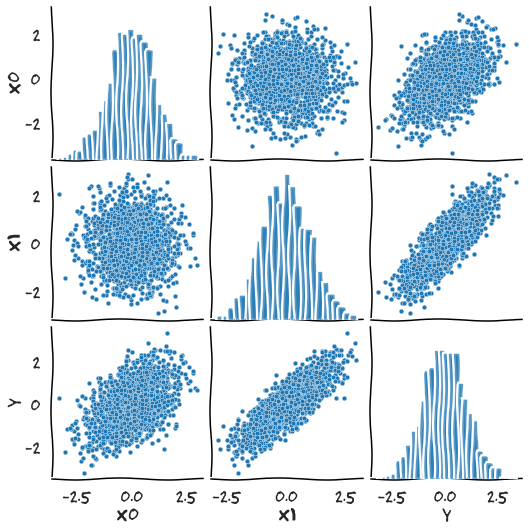

In [11]:
vars = [
    "x0",
    "x1",
    "y"
]
sns.pairplot(train_scaled_df, x_vars=vars, y_vars=vars);

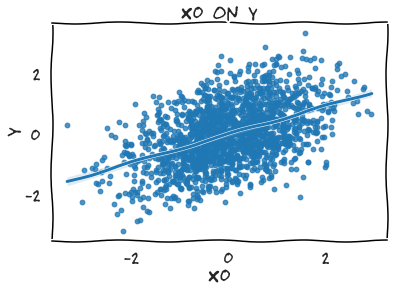

In [12]:
sns.regplot(x="x0", y="y", data=train_scaled_df).set_title('x0 on y');

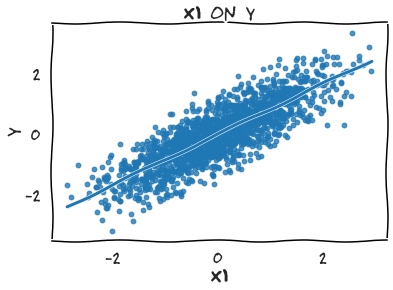

In [13]:
sns.regplot(x="x1", y="y", data=train_scaled_df).set_title("x1 on y");

## Bayes modeling
### Start with a model based on only x1
#### Define the priors of the parameters

In [14]:
priors1 = {
    "alpha": dist.Normal(0.0, 100.0),
    "beta": dist.Normal(0.0, 10.0),
    "sigma": dist.HalfNormal(10.0)
}

#### Define the model

In [15]:
def model1(X, y):
    alpha = pyro.sample("alpha", priors1["alpha"]).to(device)
    beta = pyro.sample("beta", priors1["beta"]).to(device)
    sigma = pyro.sample("sigma", priors1["sigma"]).to(device)
    mu = alpha + beta * X
    #with pyro.plate("data", X.shape[0], device=device):
    pyro.sample("y_hat", dist.Normal(mu, sigma), obs=y)

### Sample from the prior

In [16]:
from pyro.infer import Predictive

def samples2df(samples):
    """
    Alpha and y come out as single dimension vectors.
    Before creating a dataframe, these vectors are first cast to a column vector.
    """
    
    keys = samples.keys()
    
    for k in keys:
        if len(samples[k].shape) == 1:
            samples[k] = samples[k].reshape([-1,1])
    
    data=torch.hstack([samples[k] for k in samples])
    columns = [ f"{k}{j}" if samples[k].shape[1]>1 else f"{k}" for k in samples.keys() for j in range(samples[k].shape[1]) ]
    return pd.DataFrame(data=data.cpu(), columns=columns)

# Generate the prior samples
num_samples=10000
X_dummy = torch.ones([num_samples,1]).to(device)
columns = ['alpha', 'beta', 'sigma']
prior_samples = Predictive(model1, num_samples=num_samples, return_sites=columns, parallel=True)(X_dummy, None)

# Output
print(samples2df(prior_samples).head())
samples2df(prior_samples).mean()

        alpha       beta      sigma
0  -17.423256  -2.178606  13.627274
1  -97.783264   2.549439  10.874701
2    7.384446  17.888624   8.796055
3   21.612934   8.378530   4.324370
4 -241.431427  -8.623061  10.522412


alpha    0.053436
beta    -0.158295
sigma    8.020369
dtype: float32

In [17]:
from pyro.ops.stats import hpdi

def plot_regression(x, y, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = torch.argsort(x)
    x = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    y = y[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x, mean)
    ax.plot(x, y, 'o')
    ax.fill_between(x, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

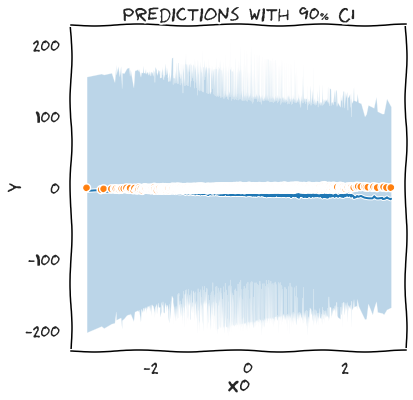

In [18]:
from pyro.infer import Predictive

X1_train = torch.from_numpy(train_scaled_df['x0'].values).to(device)
y1_train = torch.from_numpy(train_scaled_df['y'].values).to(device)

prior_predictive = Predictive(model1, num_samples=100)
prior_predictions = prior_predictive(X=X1_train, y=None)['y_hat']

mean_prior_pred = torch.mean(prior_predictions, axis=0).cpu()
hpdi_prior_pred = hpdi(prior_predictions, 0.9).cpu()

ax = plot_regression(X1_train.cpu(), y1_train.cpu(), mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel='x0', ylabel='y', title='Predictions with 90% CI');

### Render the model

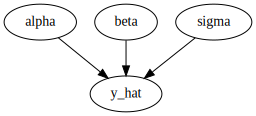

In [19]:
pyro.render_model(model1, model_args=(X_dummy, None))

### Fit the model using NUTS and MCMC

In [20]:
kernel1 = mcmc.NUTS(model1)

start = tm.time()

mcmc1 = mcmc.MCMC(kernel1,
                      num_samples=NUM_SAMPLES,
                      warmup_steps=NUM_WARMUP,
                      num_chains=NUM_CHAINS)

mcmc1.run(X1_train, y1_train)

pyro_time = tm.time() - start

Sample: 100%|█| 2000/2000 [00:38, 52.02it/s, step size=8.79e-01, acc. prob=0.895


In [57]:
mcmc1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.02     -0.00     -0.03      0.04    937.02      1.00
      beta      0.47      0.02      0.47      0.44      0.50   1192.44      1.00
     sigma      0.89      0.02      0.88      0.86      0.91   1439.16      1.00

Number of divergences: 0


### Sample the posterior parameter distribution

In [58]:
posterior_samples1 = mcmc1.get_samples(num_samples=100)
samples2df(posterior_samples1)

,alpha,beta,sigma
0,0.006114,0.472353,0.892397
1,0.021595,0.464881,0.897115
2,-0.033320,0.489285,0.903737
3,0.008985,0.459769,0.875594
4,-0.043258,0.457731,0.903695
...,...,...,...
95,-0.000932,0.466238,0.850078
96,0.014792,0.427389,0.889171
97,0.008624,0.509276,0.907930
98,0.040893,0.487342,0.887843


### Plot the predictions and interval

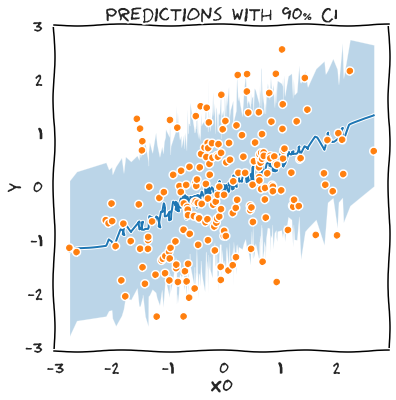

In [59]:
from pyro.infer import Predictive

posterior_predictive = Predictive(model1, posterior_samples1)
posterior_predictions = posterior_predictive(X=X1_train[:200], y=None)['y_hat']

mean_posterior_pred = torch.mean(posterior_predictions, axis=0).cpu()
hpdi_posterior_pred = hpdi(posterior_predictions, 0.9).cpu()

ax = plot_regression(X1_train[:200].cpu(), y1_train[:200].cpu(), mean_posterior_pred, hpdi_posterior_pred)
ax.set(xlabel='x0', ylabel='y', title='Predictions with 90% CI');

### Fit a model with both x1 and x2

In [61]:
X2_train = torch.from_numpy(train_scaled_df[['x0', 'x1']].values).to(device)
y2_train = torch.from_numpy(train_scaled_df['y'].values).to(device)

priors2 = {
    "alpha": dist.Normal(0.0, 100.0),
    "beta": dist.Normal(torch.zeros(2), 10.0),
    "sigma": dist.HalfNormal(10.0)
}

def model2(X, y):
    alpha = pyro.sample("alpha", priors2["alpha"]).to(device)
    beta = pyro.sample("beta", priors2["beta"]).to(device)
    sigma = pyro.sample("sigma", priors2["sigma"]).to(device)
    mu = alpha + X @ beta
    #with pyro.plate("data", X.shape[0], device=device):
    pyro.sample("y_hat", dist.Normal(mu, sigma), obs=y)
    
kernel2 = mcmc.NUTS(model2)

start = tm.time()

mcmc2 = mcmc.MCMC(kernel2,
                      num_samples=NUM_SAMPLES,
                      warmup_steps=NUM_WARMUP,
                      num_chains=NUM_CHAINS)

mcmc2.run(X2_train, y2_train)

pyro_time = tm.time() - start

Warmup:   0%|                                            | 0/2000 [00:00, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [52]:
mcmc2.summary()

NameError: name 'mcmc2' is not defined

In [160]:
samples2df(mcmc2.get_samples())

,alpha,beta0,beta1,sigma
0,45.367764,1.314128,2.357886,0.737122
1,45.367008,1.307720,2.369867,0.741095
2,45.373356,1.313851,2.338487,0.729197
3,45.371418,1.303572,2.360706,0.742346
4,45.390831,1.319818,2.350978,0.716480
...,...,...,...,...
995,45.386986,1.318869,2.370524,0.720588
996,45.350502,1.297902,2.335930,0.746398
997,45.375233,1.286908,2.380816,0.720052
998,45.369873,1.326087,2.328017,0.752624


/home/sanne/Projects/pyro/pyro-3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False


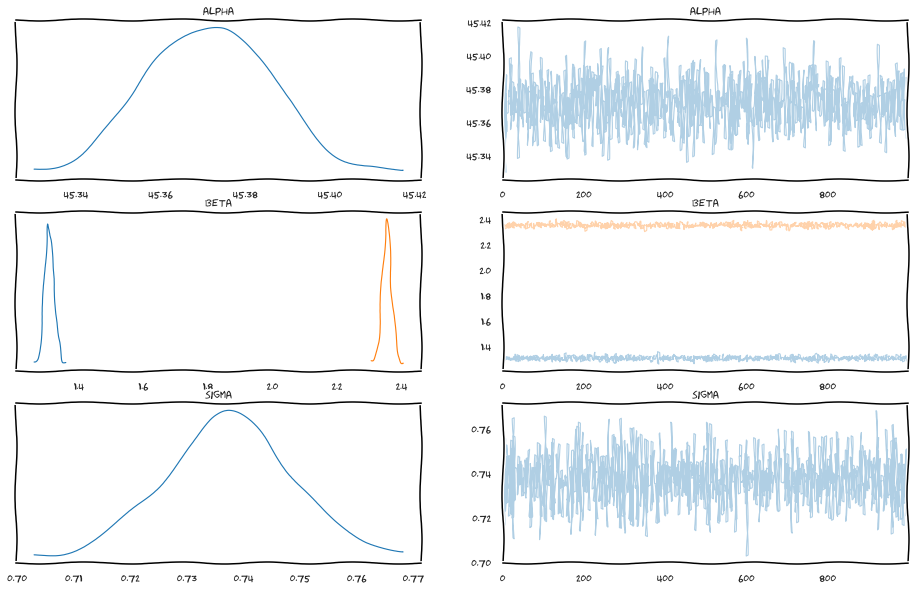

In [161]:
import arviz as az

data = az.from_pyro(mcmc2)
az.plot_trace(data, figsize=(16,10) );

In [38]:
compare_dict = {"1": az.from_pyro(posterior1), "2": az.from_pyro(posterior2)}
az.compare(compare_dict)
 

/home/sanne/Projects/pyro/pyro-3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False


TypeError: Encountered error trying to compute waic from model 1.

In [39]:
type(az.from_pyro(posterior1))

/home/sanne/Projects/pyro/pyro-3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False


arviz.data.inference_data.InferenceData